# WAV2VEC Batch Processing

Studying the properties of the [WAV2VEC v2](https://arxiv.org/abs/2006.11477) model encoder to better understand how to perform dataloading, etc.

From Section 4.2: "The feature encoder contains seven blocks and the temporal convolutions in each block have 512 channels with strides (5,2,2,2,2,2,2) and kernel widths (10,3,3,3,3,2,2).  This results in an encoder output frequency of 49Hz with a stride of about 20ms between each sample, and a receptive field of 400 input samples or 25ms of audio.  The convolutional layer modeling relative positional embeddings has a kernel size of 128 and 16 groups."

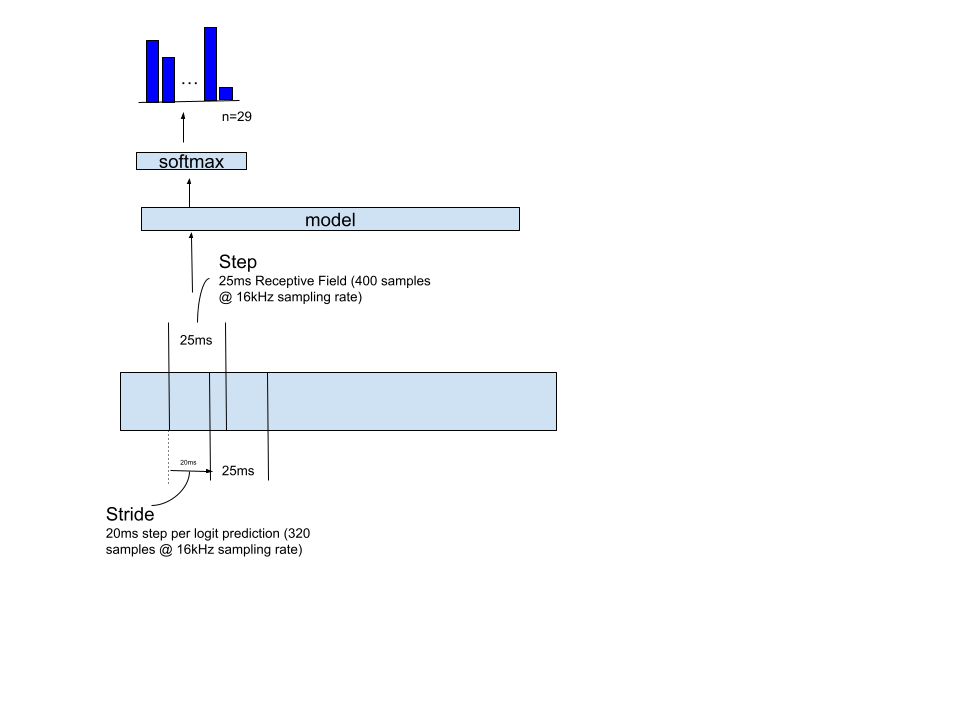

320 is the step size (20ms), 400 is the 'receptive field' (25ms).  The first step is 400 samples, the rest have an overlap so the 400 sample window shifts by 320.<br>

1200 sample example:<br>
Step 1: 400 input samples (i.e. sampes 0 to 399)<br>
Step 2: 400 input samples (i.e. samples 320 to 719 - note the shift)<br>
Step 3: 400 input samples (i.e. samples 720 to 1019)<br>

ALSO, each step benefits from many adjacent samples because the decoding **can** occur across as many steps possible, so the more input samples are provided simultaneously the better a LM or decoder may be able to decode characters.

Note: less than 720 samples only gives you one guess, which means that it is ignoring all samples above 400 until you have enough for a second sample (i.e. it doesn't pad them).



In [85]:
import os
import time

import torch
import torchaudio

import numpy as np
import matplotlib.pyplot as plt

from torchaudio.models.decoder import ctc_decoder
from torchaudio.models.decoder import download_pretrained_files

torch.random.manual_seed(42)
device = torch.device('mps')

# Loading ASR Model
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)

# more information on labels can be found here: 
# https://pytorch.org/audio/stable/generated/torchaudio.pipelines.Wav2Vec2ASRBundle.html#torchaudio.pipelines.Wav2Vec2ASRBundle
print(bundle.get_labels())

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [86]:
SPEECH_FILE = "data/mary_had_a_little_lamb_spoken.wav"

if os.path.exists(SPEECH_FILE):
    waveform, sample_rate = torchaudio.load(SPEECH_FILE)
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    waveform = waveform.to(device)
print(waveform.shape)

def do_single_inference(input_waveform, samples):
    start = time.time()
    waveform = torch.reshape(input_waveform[0,:samples], (1, -1))
    print(waveform.shape)
    start = time.time()
    with torch.inference_mode():
        emission, _ = model(waveform)
    end = time.time()
    print(emission.shape)
    #print(f"{waveform.shape[0] * 4 / 1e6:.5f}MB of data.")
    print(f'Finished in {end-start:.3f}s for {(waveform.shape[1] / 16000):.3f}s song.')
    return emission

torch.Size([1, 355872])


In [87]:
files = download_pretrained_files("librispeech-4-gram")
LM_WEIGHT = 3.23
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=files.tokens,
    lm=files.lm,
    nbest=3,
    beam_size=1500,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

**Doing Inference with less than 400 samples will result in an error.**

In [88]:
try:
    do_single_inference(waveform, 399)
except Exception as e:
    print('Runtime error.  Not enough Samples.')

torch.Size([1, 399])
Runtime error.  Not enough Samples.


**Doing Inference with 400 to 720 will result in 1 guess**

In [89]:
try:
    do_single_inference(waveform, 719)
except Exception as e:
    print('Runtime error.  Not enough Samples.')

torch.Size([1, 719])
torch.Size([1, 1, 29])
Finished in 0.070s for 0.045s song.


**If you put the whole waveform in, you get as many output emissions out as possible**

In [93]:
chan, num_samples = waveform.shape
do_single_inference(waveform, num_samples);

torch.Size([1, 355872])
torch.Size([1, 1111, 29])
Finished in 0.198s for 22.242s song.


In [94]:
print(f"{np.floor((num_samples - 400) / 320 +1): .0f} model emissions.")

 1111 model emissions.


**Pytorch will just consume your memory if you provide it more and more data...**

In [97]:
# Dont Run this unless you really want to.  
concatenated_waveform = torch.cat([waveform] * 10, dim=1)
chan, num_samples = concatenated_waveform.shape
try: 
    do_single_inference(concatenated_waveform, num_samples)
except Exception as e:
    print('Runtime Error: likely out of memory!')
del concatenated_waveform

torch.Size([1, 3558720])
Runtime Error: likely out of memory!


# Batch Processing

Batch processing is baked into the model.  first dimension is used for the batch size.  Two dimensional data should be combined to a single channel.

In [98]:
def do_batch_inference(batch_waveforms):
    start = time.time()
    print(batch_waveforms.shape)
    start = time.time()
    with torch.inference_mode():
        emission, _ = model(batch_waveforms)
    end = time.time()
    print(emission.shape)
    #print(f"{waveform.shape[0] * 4 / 1e6:.5f}MB of data.")
    print(f'Finished in {end-start:.3f}s for {(batch_waveforms.shape[1] / 16000):.3f}s set of {batch_waveforms.shape[0]} songs.')

print(waveform.shape)
stacked_waveform = torch.cat([waveform]*10, dim=0)
do_batch_inference(stacked_waveform)
del stacked_waveform

torch.Size([1, 355872])
torch.Size([10, 355872])
torch.Size([10, 1111, 29])
Finished in 9.835s for 22.242s set of 10 songs.


# Logits and Padding

In order to do batch processing padding is necessary.  WER is mostly unaffected as the vocab is blank if the probability is low.  In the two examples below one is plotting the emissions (y-axis are the logit max values, x is the 20ms emissions.  The second example, the input data is zero padded at the end and the resulting transcript is identical.   

(1, 1111)
mary had a little lamb little lamb little lamb mary had a little lamb her fleece was white as snow everywhere that mary went mary went mary went everywhere that mary went the lamb was sure to go


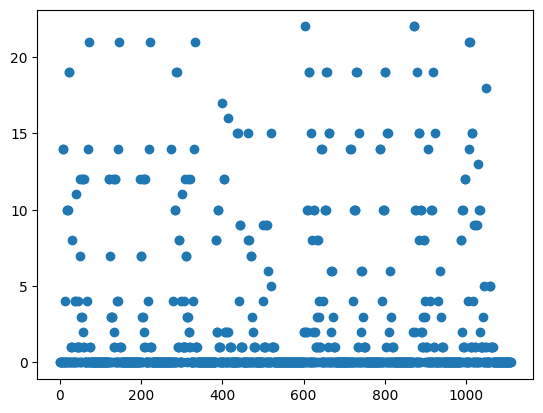

In [99]:
chan, num_samples = waveform.shape
with torch.inference_mode():
    emissions, _ = model(waveform)
    beam_search_result = beam_search_decoder(emission)
    
# Copy the tensor back to CPU memory
emissions_cpu = emissions.cpu()
emissions_numpy = emissions_cpu.numpy()

greedy = np.argmax(emissions_numpy,axis=2)
print(greedy.shape)
plt.plot(greedy[0],'o');
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
print(beam_search_transcript)

(1, 2223)
mary had a little lamb little lamb little lamb mary had a little lamb her fleece was white as snow everywhere that mary went mary went mary went everywhere that mary went the lamb was sure to go


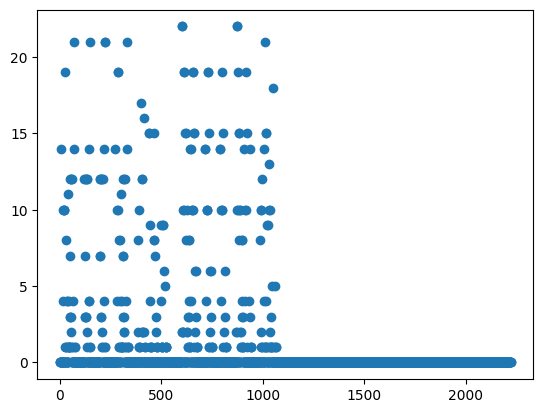

In [100]:
# Create a tensor of zeros with the same size as waveform
zeros_tensor = torch.zeros_like(waveform)

# Concatenate the zeros tensor to the waveform tensor along the first dimension (axis=0)
concatenated_zeros_waveform = torch.cat([waveform, zeros_tensor], dim=1)
chan, num_samples = concatenated_zeros_waveform.shape

with torch.inference_mode():
    emissions, _ = model(concatenated_zeros_waveform)
    beam_search_result = beam_search_decoder(emission)
    
# Copy the tensor back to CPU memory
emissions_cpu = emissions.cpu()
emissions_numpy = emissions_cpu.numpy()

greedy = np.argmax(emissions_numpy,axis=2)
print(greedy.shape)
plt.plot(greedy[0],'o');
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
print(beam_search_transcript)